In [31]:
import torch
import data_loader
from traineval import train, evaluate
import model_impl as model

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load data

The following line of code invokes data_loader and will automatically download and extract the dataset if needed.
It instantiates the following variables;
* tokens_vocab - the sentence words vocabulary
* y_vocab - the labels (senses) vocabulary
* datasets - a dictionary with train,dev, and test WSDDataset instances.

Use the optional sentence_count kwarg to limit the number of sentences loaded.

In [32]:
datasets, tokens_vocab, y_vocab = data_loader.load(['train', 'dev'], sentence_count=100)
datasets['train']

Samples: 742 (no_sense: 0)
Sentences: 100 (N=76)
Vocab:
	Tokens:1663
	Senses:890

In [33]:
datasets['dev']

Samples: 589 (no_sense: 0)
Sentences: 100 (N=64)
Vocab:
	Tokens:1663
	Senses:890

## Ex2A.1: Implement and train a basic attention model

In [34]:
dropout = 0.25
D = 300

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

In [35]:
lr = 8e-5
batch_size=100
num_epochs=10

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, datasets['train'], datasets['dev'], num_epochs=num_epochs, batch_size=batch_size)

print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")

[9] loss: 6.628: 100%|██████████| 8/8 [00:00<00:00, 23.13it/s]


Validation accuracy: 0.032, Training accuracy:0.106


### Plot loss and train/val accuracy

You should be getting ~54% validation accuracy after 10 epochs.

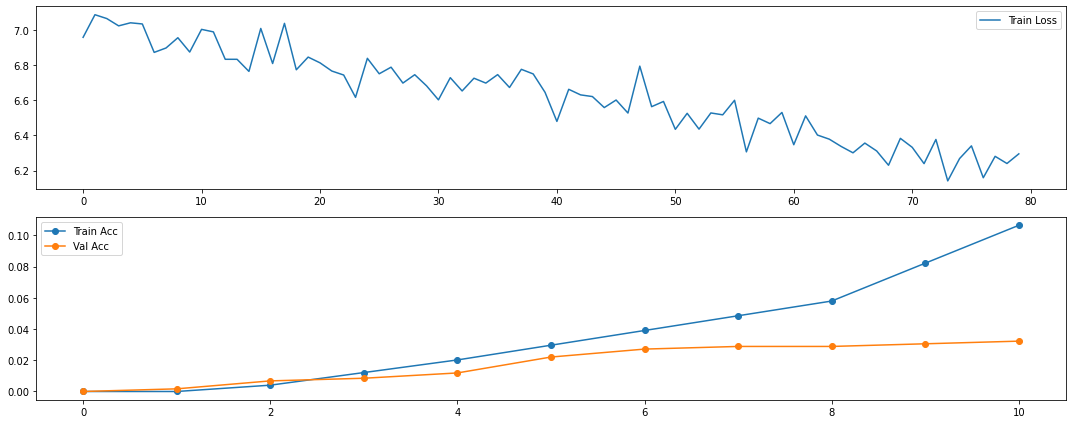

In [36]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

### Inspect attention

Invoke the attention highlight vizualization to get a feel of what attention is doing.

The query token is highlighted green, and the model's attention with pink-blue gradient.
In addition, the loss is given a red gradient.

In [37]:
from traineval import higlight_samples

higlight_samples(m, datasets['dev'], sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,6,Linda,person.n.01,age.n.01,1.142e-03,6.774926,But,there,was,no,need,for,Linda,Kay,to,go,on,",",since,all,she,wanted,in,life,was,to,make,a,home,for,Bobby,Joe,and,(,blushing,),raise,his,children,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,8,hour,hour.n.02,n't.r.00,1.298e-03,6.646711,Nothing,like,Godot,",",he,arrived,before,the,hour,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,16,Maturity,maturity.n.02,potential.a.01,1.328e-03,6.623838,There,the,middle,one,of,the,three,curves,denotes,``,mean,Skeletal,Age,'',for,the,Maturity,Series,boys,and,girls,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,0,Gun,person.n.01,potential_energy.n.01,1.506e-03,6.498226,Gun,waited,for,Killpath,to,sit,down,behind,the,desk,near,the,window,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,2,Byron,person.n.01,agree.v.01,9.983e-04,6.909310,They,recall,Byron,'s,classic,comment,:,``,I,wish,he,would,explain,his,explanation,'',.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Notice how the model gives attention to the padded indices.

## Ex2A.2: Attending Padding

In [38]:
m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

losses, train_acc, val_acc = train(
    m, optimizer, datasets['train'], datasets['dev'], num_epochs=num_epochs, batch_size=batch_size)

[9] loss: 6.994: 100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


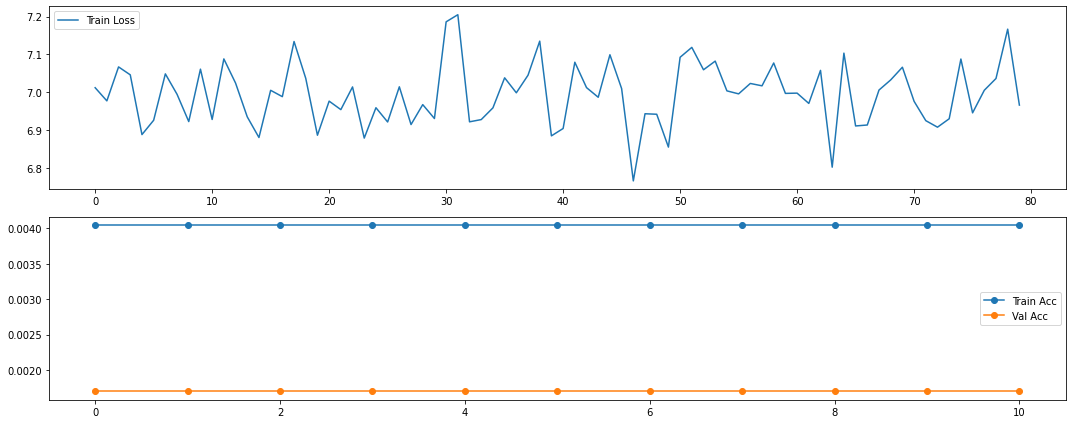

In [39]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [40]:
higlight_samples(m, datasets['dev'], sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,22,ball,ball.n.06,north.r.01,1.109e-03,6.804317,His,hands,snatched,at,an,imaginary,bucket,",",swooping,down,hard,to,grab,it,and,coming,away,with,equal,snap,like,a,ball,that,'s,been,bounced,hard,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,24,land,land.n.01,moon.n.01,1.382e-03,6.584268,Most,counties,also,have,maps,available,from,the,county,engineer,showing,roads,and,other,features,and,from,the,assessor,'s,office,showing,ownerships,of,land,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,21,ordinarily,normally.r.01,difference.n.01,8.836e-04,7.031403,When,the,same,sequence,is,equivalent,in,meaning,to,I,have,instructions,which,I,am,to,leave,",",dominant,stress,is,ordinarily,on,instructions,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,10,wife,wife.n.01,gigantic.s.01,3.206e-04,8.044856,``,Now,he,'s,bought,it,'',",",said,my,wife,contentedly,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,8,frequencies,low_frequency.n.01,respective.s.01,3.456e-04,7.969806,Since,conventional,methods,are,insensitive,at,the,low,frequencies,of,these,molecular,transitions,",",the,paramagnetic,resonance,method,is,being,used,instead,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


#### If you like, feel free to inspect more samples, using the api and pandas as demonstrated below.

In [41]:
import pandas as pd
import numpy as np
from traineval import evaluate_verbose, highlight

pd.set_option('max_columns', 100)

eval_df, attention_df = evaluate_verbose(m, datasets['dev'], iter_lim=100)

#### Show 5 correctly classified samples

In [42]:
idxs = np.where(eval_df['y_true'] != eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,8,swooping,pounce.v.01,experience.n.02,1.144e-03,6.772799,His,hands,snatched,at,an,imaginary,bucket,",",swooping,down,hard,to,grab,it,and,coming,away,with,equal,snap,like,a,ball,that,'s,been,bounced,hard,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,stopped,stop.v.01,platform.n.01,9.280e-04,6.982356,He,stopped,automatically,at,the,street,corners,",",waiting,for,the,traffic,lights,to,change,",",unheeding,of,other,people,",",his,coat,open,and,flapping,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,8,cooked,cook.v.01,greatest.s.00,1.160e-03,6.758923,Carol,Strong,",",13,",",of,Cedar,Mill,cooked,the,championship,junior,dollar,dinner,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,12,are,be.v.01,consequence.n.03,1.129e-03,6.785898,Fundamentally,",",both,these,types,",",the,amateur,and,the,collector,",",are,uncritical,and,many,of,them,do,n't,distinguish,well,between,real,folklore,and,bogus,material,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,30,energy,kinetic_energy.n.01,series.n.01,7.526e-04,7.191902,If,such,is,the,case,",",the,particles,within,a,distance,of,about,*,*,f,km,of,the,Earth,will,have,",",relative,to,the,Earth,",",a,kinetic,energy,less,than,their,potential,energy,and,they,will,be,captured,into,orbits,about,the,Earth,.,,,,,,,,,,,,,,,,,


#### Show samples of the query word 'left'

In [43]:
idxs = np.where(eval_df['query_token'] == 'left')
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
25,25,5,left,leave.v.02,note.v.03,9.710e-04,6.937057,My,men,",",they,all,left,me,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Ex2A.3: Self Attention

The method below converts the word level WSDDataset instances to sentence level dataset instances WSDSentencesDataset for self attention mode.

Notice how the number of samples now equals number of sentences.

In [44]:
sa_datasets = data_loader.WSDSentencesDataset.from_word_datasets(datasets)
sa_datasets['train']

Samples: 100
Sentences: 100 (N=76)
Vocab:
	Tokens:1663
	Senses:890

### Imeplement and train

In [45]:
lr=2e-4
dropout = 0.2
D=300
batch_size=100
num_epochs=5

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_datasets['train'], sa_datasets['dev'], num_epochs=num_epochs, batch_size=batch_size)

[4] loss: 6.826: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


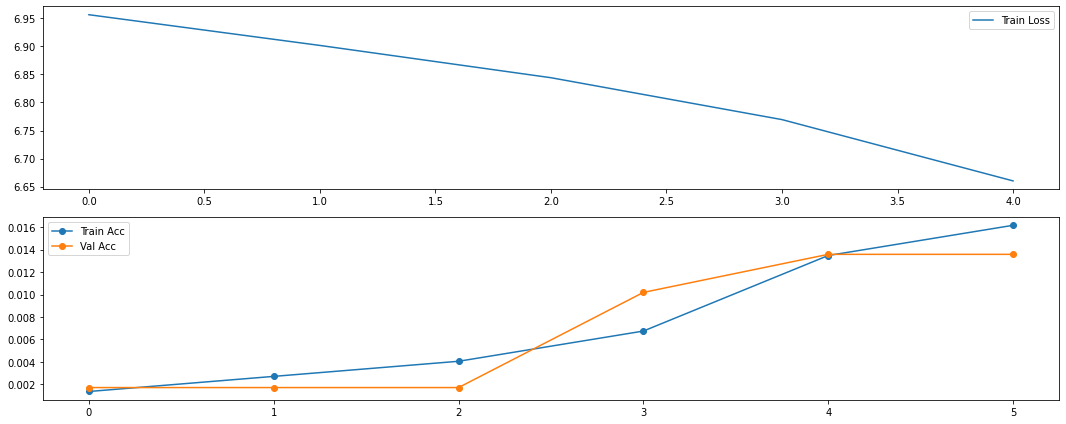

In [46]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

# Ex 2B: Position-Sensitive Attention

# Ex 2C: Causal Attention